# Теория

Уменьшение размерности --  задача из машинного обучения (изначально -- из статистики), где алгоритм "собирает" многочисленные признаки в высокоуровневые абстракции.

**Где используется уменьшение размерности:**<br>
- Рекомендательные системы
- Риск-менеджмент
- Красивые визуализации
- Определение похожих текстов (тематическое моделирование)


**Популярные алгоритмы:** <br>
- Метод главных компонент (PCA)
- Латентное размещение Дирихле (LDA)
- Сингулярное разложение (SVD)
- t-SNE, UMAP (для визуализации)

**Как работает объединение признаков в абстракцию:**<br>
 - CV: "собака с треугольными ушами" + "с длинным носом" + "с большим хвостом" >> овчарка
 - NLP:  текст с фразами "нарезать кубиками", "200 грамм", "при температуре" >> кулинарный рецепт
 - RecSys: "пользователь слушает Alice Coltrane" + "лайкнул альбом Луи Армстронга" >> любитель джаза

! *важно отметить, что не все абстракции хорошо интерпретируемы (тк мы работаем с многомерными пространствами)*

Уменьшение размерности хорошо работает для определения тематик текстов (Topic Modelling). Идея такая же: документ с текстом представляют как некоторую абстракцию из более низкоуровневых признаков. 

# Практика

Сегодня будем делать топик-моделлинг на [корпусе новостей](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)

наши алгоритмы --- LDA (Latent Dirichlet Allocation), SVD (Single Value Decomosition) и NMF (Non-negative Matrix Factorization).

## LDA

- Корпус -- это коллекция из D документов.

- Документ состоит из N слов.

- В одном документе может встретиться K тем.

Слова в корпусе -- единственная явная переменная. Скрытые (латентные) переменные - это распределение тем в корпусе и распределение слов в документе. Задача алгоритма LDA -- используя наблюдаемые слова извлечь информацию о структуре тем в корпусе.

Для LDA нужны две матрицы: *“темы x слова"* и  *“документы x темы”*. 
Они получаются из матрицы "документы x слова"

In [1]:
import matplotlib.pyplot as plt # viz
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # векторизация текстов
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF # dimred

from sklearn.datasets import fetch_20newsgroups # data

import warnings
warnings.filterwarnings("ignore")

In [39]:
# зададим несколько переменных, будем использовать их как параметры функций

n_samples = 2000 # размер корпуса
n_features = 1000 # максимальное количество слов в матрице "слово x документ" (= top1000 частотных их всех в корпусе)
n_components = 10 # число тем в корпусе
n_top_words = 10 # порог частотности для визуализаций

Сначала загрузим датасет и возьмем оттуда только текстовую часть (без заголовков, сносок и тд)

In [4]:
# если возникает ошибка загрузки, раскомментьте ячейки ниже
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


data, _ = fetch_20newsgroups(remove=('headers', 'footers','quotes'),
                             return_X_y=True) # y нам не нужен, на самом деле
print(data[100:150])

['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't an

In [5]:
len(data)

11314

### для работы возьмем часть датасета

In [10]:
# первые 2К документов

data_samples = data[:n_samples] 
print("Общий датасет: {} документов;\nФрагмент для работы: {} документов".format(len(data),len(data_samples)))


Общий датасет: 11314 документов;
Фрагмент для работы: 2000 документов


In [ ]:
 # рандомные 2К документов
import pandas as pd

data_df = pd.DataFrame(data)
data_df.head()
data_samples = data_df.sample(n=n_samples)
data_samples = data_samples[0].to_list()


print("Общий датасет: {} документов;\nФрагмент для работы: {} документов".format(len(data),len(data_samples)))

Теперь документы надо векторизовать

In [18]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data_samples)

In [14]:
display(type(tf_vectorizer))
display(type(tf))

sklearn.feature_extraction.text.CountVectorizer

scipy.sparse.csr.csr_matrix

In [20]:
display(tf.shape) # матрица "слова x документы"

tf_vectorizer.get_feature_names()[700:1000]

(2000, 1000)

['posted',
 'posting',
 'postscript',
 'power',
 'pp',
 'present',
 'president',
 'press',
 'pressure',
 'pretty',
 'prevent',
 'price',
 'print',
 'printer',
 'privacy',
 'private',
 'pro',
 'probably',
 'problem',
 'problems',
 'process',
 'product',
 'program',
 'programs',
 'project',
 'protect',
 'provide',
 'provided',
 'ps',
 'pt',
 'pts',
 'pub',
 'public',
 'published',
 'purpose',
 'que',
 'question',
 'questions',
 'quite',
 'quote',
 'radio',
 'ram',
 'random',
 'range',
 'rate',
 'rates',
 'read',
 'reading',
 'real',
 'reality',
 'really',
 'reason',
 'reasonable',
 'reasons',
 'received',
 'recent',
 'recently',
 'record',
 'red',
 'reference',
 'regarding',
 'related',
 'release',
 'religion',
 'religious',
 'remember',
 'reply',
 'report',
 'require',
 'required',
 'research',
 'response',
 'rest',
 'result',
 'results',
 'return',
 'right',
 'rights',
 'risk',
 'rkba',
 'road',
 'robert',
 'rockefeller',
 'rules',
 'run',
 'running',
 'runs',
 'russian',
 'safe',
 'sa

Теперь отдадим эту матрицу алгоритму снижения размерности

параметры в скобках: 
- n_components: число тем в корпусе
-  max_iter: количество итераций алгоритма
- learning_offset: параметр, который занижает значение ранних итераций (тк более важная часть обучения случается на поздних), обычно устанавливается больше чем 1 

[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#examples-using-sklearn-decomposition-latentdirichletallocation)

In [37]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20,learning_offset=50)

lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=20)

In [23]:
lda.components_.shape

(10, 1000)

используем функцию для упрощения визуализации топа частотности по темам:  

In [40]:
def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(2, 5, figsize=(30, 15)) # параметры отображения 
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1] 
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь
        
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

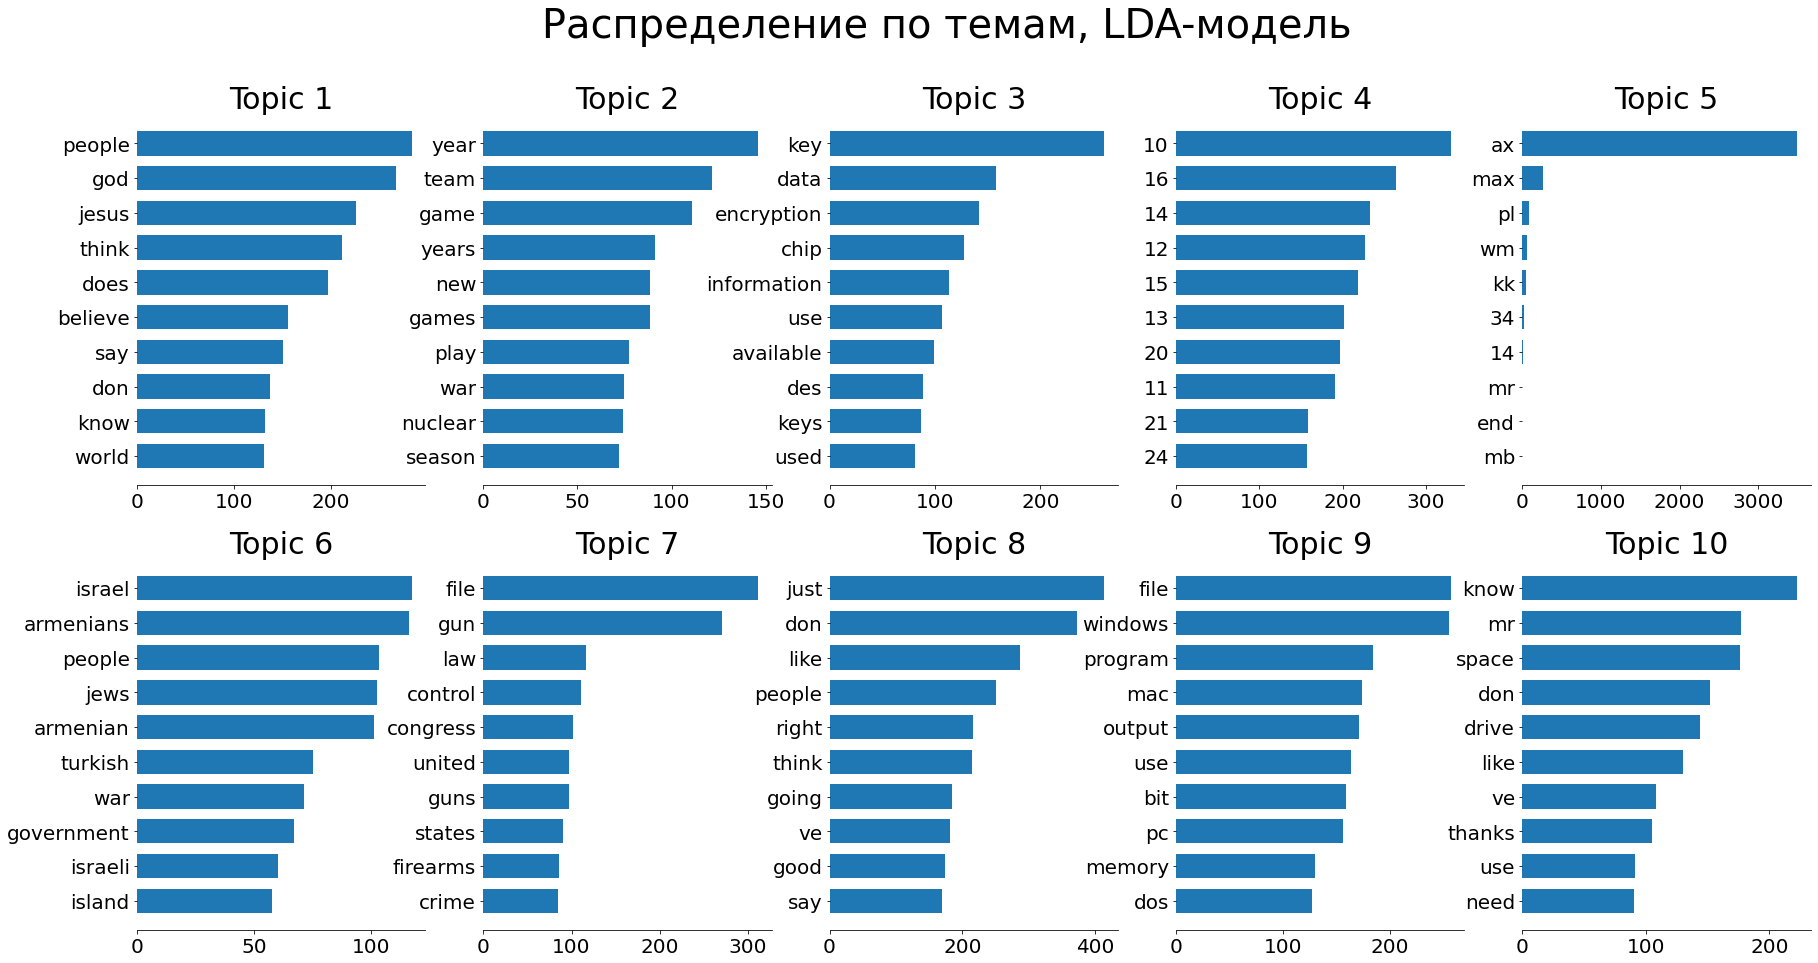

In [41]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lda, tf_feature_names, n_top_words, 'Распределение по темам, LDA-модель')

In [61]:
# https://stackoverflow.com/questions/45145368/python-scikit-learn-get-documents-per-topic-in-lda

def get_top_words(model, feature_names, n_top_words):
    # all_features = {}
    
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    #     all_features.update((topic_idx," ".join([feature_names[i]
    #                     for i in topic.argsort()[:-n_top_words - 1:-1]]).split()))
    # return all_features


In [68]:
lda.components_.shape

(10, 1000)

In [63]:
get_top_words(lda,tf_feature_names, 20)

Topic #0:
people, god, jesus, think, does, believe, say, don, know, world, true, way, like, time, just, make, point, church, good, truth
Topic #1:
year, team, game, years, new, games, play, war, nuclear, season, time, flyers, secret, moon, players, got, good, base, points, military
Topic #2:
key, data, encryption, chip, information, use, available, des, keys, used, technology, faq, bit, number, list, keyboard, clipper, access, chips, product
Topic #3:
10, 16, 14, 12, 15, 13, 20, 11, 21, 24, 30, 17, 25, 18, 19, la, 23, 22, 27, 00
Topic #4:
ax, max, pl, wm, kk, 34, 14, mr, end, mb, bos, solution, politics, talk, results, written, doubt, senate, fast, experience
Topic #5:
israel, armenians, people, jews, armenian, turkish, war, government, israeli, island, jewish, years, south, history, daughter, genocide, turks, men, said, georgia
Topic #6:
file, gun, law, control, congress, united, guns, states, firearms, crime, new, national, state, american, 1993, house, mr, use, 1992, study
Topic #7:

**распределение документов по темам**

In [69]:
doc_topic = lda.transform(tf)


for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()+1 
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 9

doc: 1 topic: 1

doc: 2 topic: 8

doc: 3 topic: 9

doc: 4 topic: 8

doc: 5 topic: 1

doc: 6 topic: 8

doc: 7 topic: 8

doc: 8 topic: 10

doc: 9 topic: 8

doc: 10 topic: 1

doc: 11 topic: 1

doc: 12 topic: 8

doc: 13 topic: 8

doc: 14 topic: 9

doc: 15 topic: 9

doc: 16 topic: 8

doc: 17 topic: 10

doc: 18 topic: 10

doc: 19 topic: 1

doc: 20 topic: 8

doc: 21 topic: 10

doc: 22 topic: 8

doc: 23 topic: 1

doc: 24 topic: 10

doc: 25 topic: 8

doc: 26 topic: 2

doc: 27 topic: 8

doc: 28 topic: 8

doc: 29 topic: 9

doc: 30 topic: 1

doc: 31 topic: 6

doc: 32 topic: 1

doc: 33 topic: 2

doc: 34 topic: 7

doc: 35 topic: 7

doc: 36 topic: 10

doc: 37 topic: 4

doc: 38 topic: 10

doc: 39 topic: 8

doc: 40 topic: 10

doc: 41 topic: 1

doc: 42 topic: 3

doc: 43 topic: 1

doc: 44 topic: 10

doc: 45 topic: 8

doc: 46 topic: 8

doc: 47 topic: 10

doc: 48 topic: 8

doc: 49 topic: 8

doc: 50 topic: 1

doc: 51 topic: 8

doc: 52 topic: 1

doc: 53 topic: 1

doc: 54 topic: 3

doc: 55 to

In [66]:
doc_topic.shape

(2000, 10)

## SVD

Уменьшение размерности с помощью метода SVD часто называется латентным семантическим анализом (LSA)

[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [70]:
# обучаем модель
lsa_model = TruncatedSVD(n_components=n_components)

lsa_topic_matrix = lsa_model.fit_transform(tf)

In [72]:
lsa_topic_matrix.shape

(2000, 10)

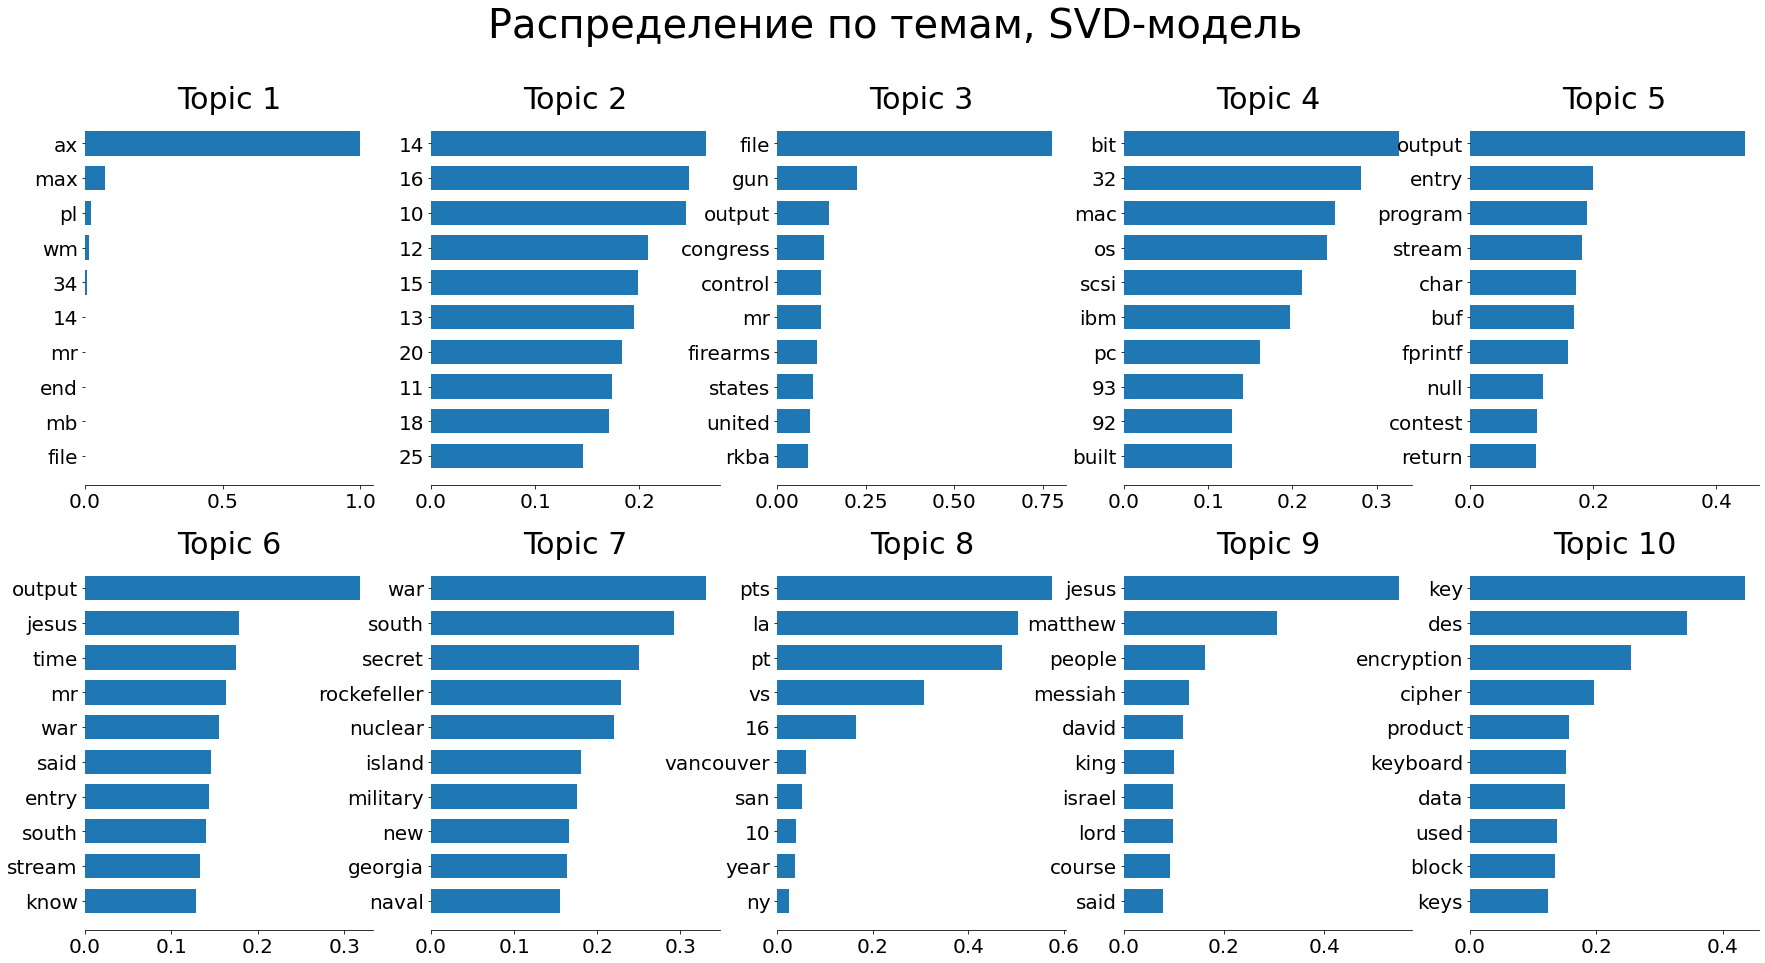

In [73]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lsa_model, tf_feature_names, n_top_words, 'Распределение по темам, SVD-модель')

In [75]:
get_top_words(lsa_model,tf_feature_names, 20)

Topic #0:
ax, max, pl, wm, 34, 14, mr, end, mb, file, output, 16, 10, 32, 12, buf, 15, program, 13, entry
Topic #1:
14, 16, 10, 12, 15, 13, 20, 11, 18, 25, 17, 21, 19, file, 27, 24, 23, 32, 30, 26
Topic #2:
file, gun, output, congress, control, mr, firearms, states, united, rkba, house, program, 1991, entry, 1993, 1992, use, handgun, law, new
Topic #3:
bit, 32, mac, os, scsi, ibm, pc, 93, 92, built, hardware, use, color, like, used, ram, dos, standard, 16, software
Topic #4:
output, entry, program, stream, char, buf, fprintf, null, contest, return, line, build, section, input, write, info, define, open, rules, read
Topic #5:
output, jesus, time, mr, war, said, entry, south, stream, know, buf, char, program, secret, people, fprintf, don, rockefeller, nuclear, going
Topic #6:
war, south, secret, rockefeller, nuclear, island, military, new, georgia, naval, plan, british, world, attack, united, april, friends, audio, base, russian
Topic #7:
pts, la, pt, vs, 16, vancouver, san, 10, year, ny

In [76]:
for n in range(lsa_topic_matrix.shape[0]):
    topic_most_pr = lsa_topic_matrix[n].argmax()+1 
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 4

doc: 1 topic: 6

doc: 2 topic: 8

doc: 3 topic: 4

doc: 4 topic: 6

doc: 5 topic: 10

doc: 6 topic: 6

doc: 7 topic: 6

doc: 8 topic: 10

doc: 9 topic: 9

doc: 10 topic: 1

doc: 11 topic: 6

doc: 12 topic: 6

doc: 13 topic: 4

doc: 14 topic: 6

doc: 15 topic: 6

doc: 16 topic: 6

doc: 17 topic: 4

doc: 18 topic: 6

doc: 19 topic: 10

doc: 20 topic: 6

doc: 21 topic: 6

doc: 22 topic: 4

doc: 23 topic: 6

doc: 24 topic: 4

doc: 25 topic: 6

doc: 26 topic: 2

doc: 27 topic: 6

doc: 28 topic: 6

doc: 29 topic: 4

doc: 30 topic: 9

doc: 31 topic: 6

doc: 32 topic: 6

doc: 33 topic: 6

doc: 34 topic: 3

doc: 35 topic: 6

doc: 36 topic: 4

doc: 37 topic: 2

doc: 38 topic: 4

doc: 39 topic: 6

doc: 40 topic: 3

doc: 41 topic: 1

doc: 42 topic: 10

doc: 43 topic: 4

doc: 44 topic: 6

doc: 45 topic: 6

doc: 46 topic: 6

doc: 47 topic: 6

doc: 48 topic: 6

doc: 49 topic: 4

doc: 50 topic: 9

doc: 51 topic: 6

doc: 52 topic: 6

doc: 53 topic: 2

doc: 54 topic: 4

doc: 55 topic: 6

##  NMF
NMF -- альтернативный способ разложения матрицы, который подразумевает, что данные не-негативные (т.е. >=0). 
NMF часто заменяет PCA. При разложении изначальная матрица превращается в две, при этом оптимизируются два параметра: расстояние между матрицами и их произведение.


[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)

In [77]:
# для NMF понадобится tf-idf-векторизация, тк tf-idf не бывает негативным

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(data_samples)


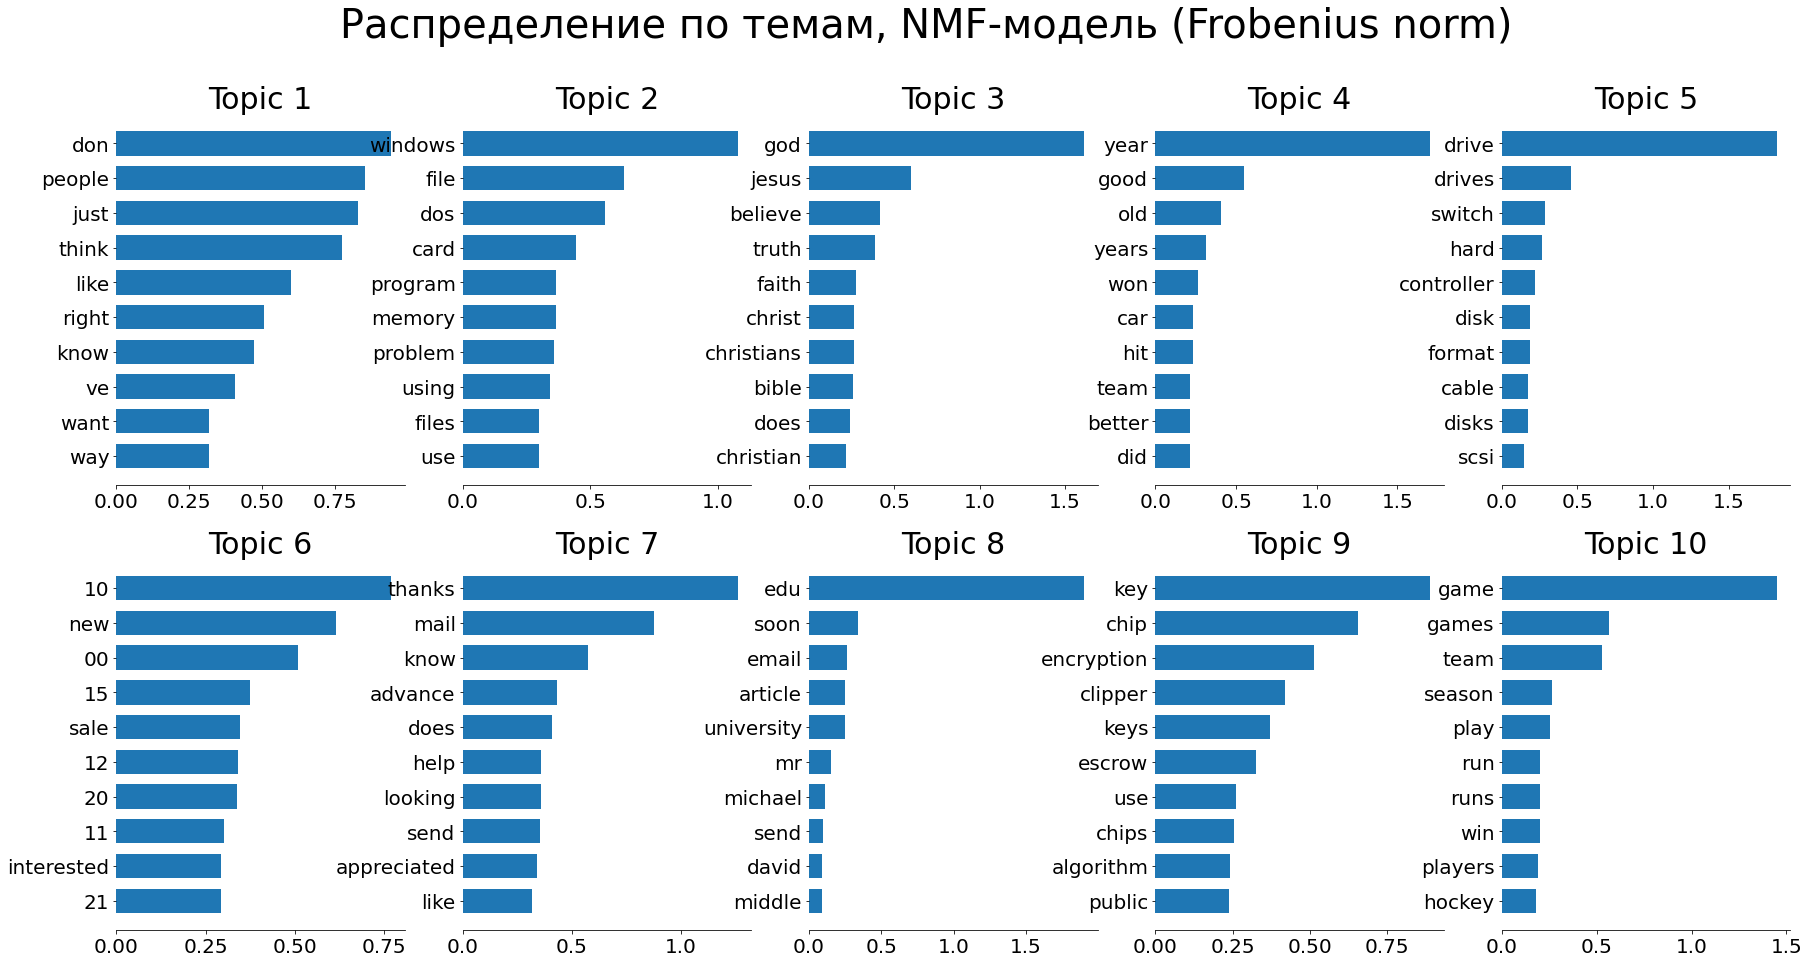

In [78]:
# обучаем первую модель

nmf = NMF(n_components=n_components).fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель (Frobenius norm)')

Для второй версии добавим параметров:

- beta-loss : мера оптимизации расстояния между матрицами (дивергенции)
- solver: еще один параметр оптимизации, для KL-дивергенции нужен Multiplicative Update ('mu')

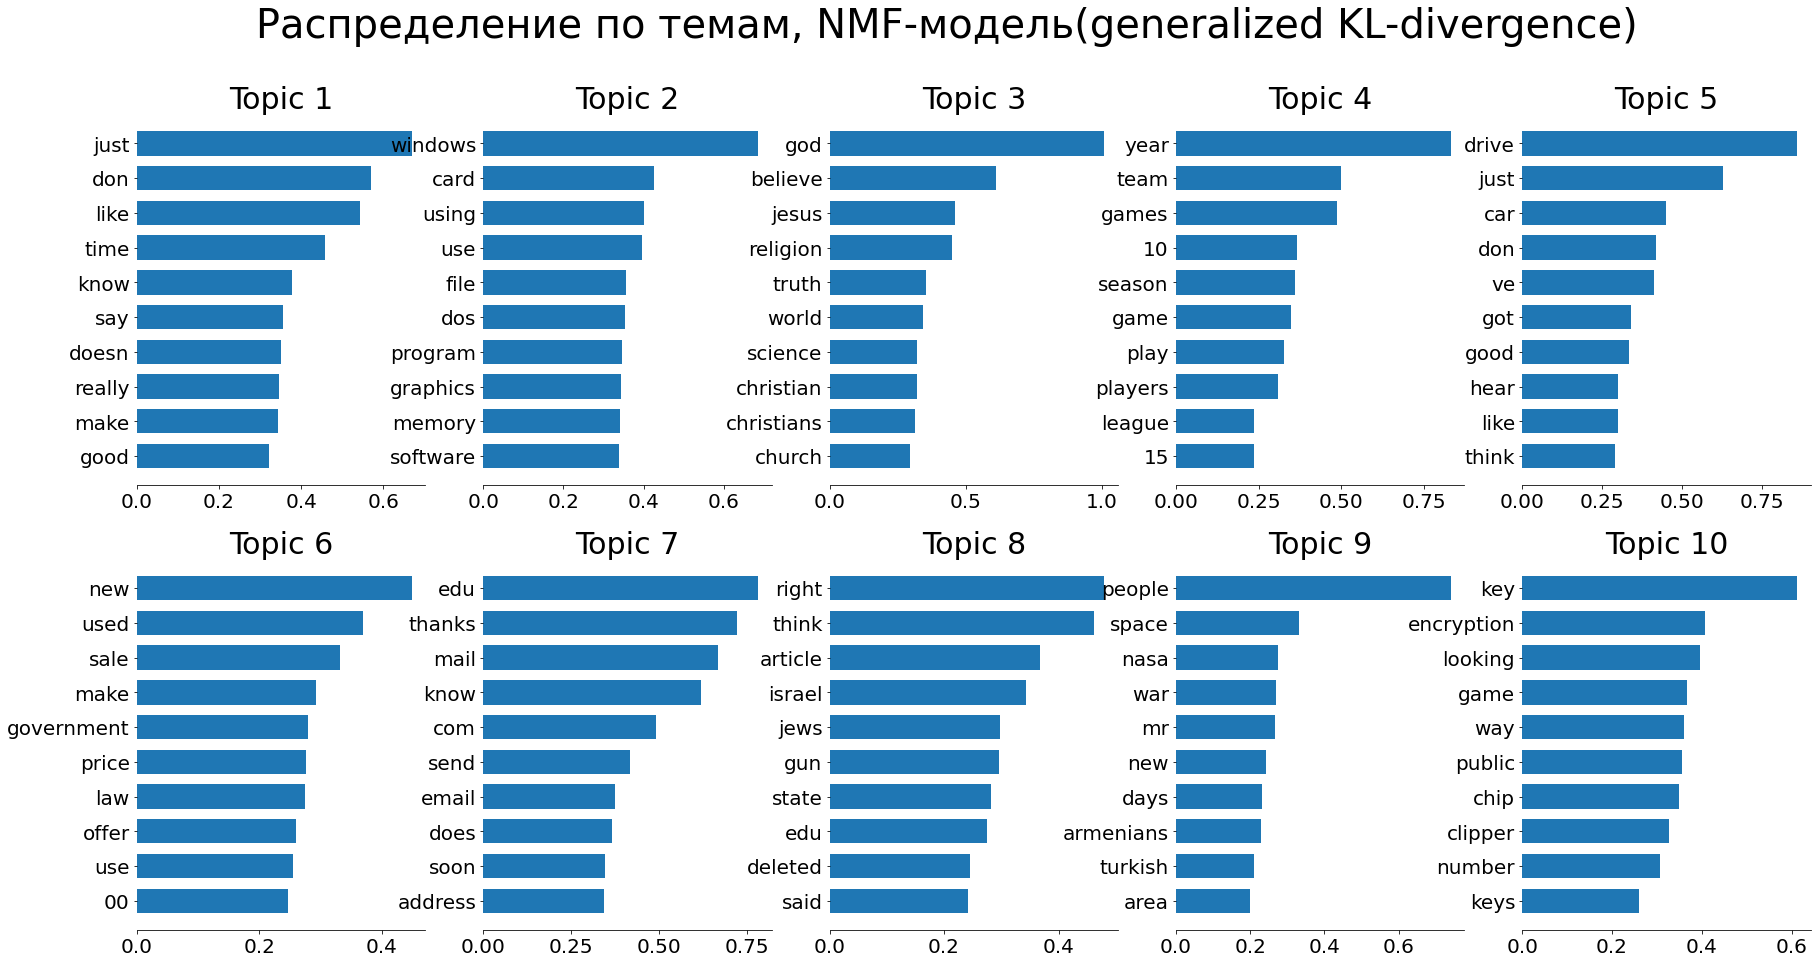

In [79]:
# обучаем вторую модель

nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', solver='mu').fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель(generalized KL-divergence)')


In [80]:
get_top_words(nmf,tf_feature_names, 20)

Topic #0:
just, don, like, time, know, say, doesn, really, make, good, think, point, going, look, ve, long, sure, actually, better, real
Topic #1:
windows, card, using, use, file, dos, program, graphics, memory, software, files, mac, pc, thanks, monitor, video, ftp, color, window, hi
Topic #2:
god, believe, jesus, religion, truth, world, science, christian, christians, church, question, true, people, bible, christianity, does, jewish, christ, book, faith
Topic #3:
year, team, games, 10, season, game, play, players, league, 15, hit, 24, 11, 12, hockey, best, win, toronto, 21, 20
Topic #4:
drive, just, car, don, ve, got, good, hear, like, think, drives, hard, problems, speed, bus, little, controller, problem, pretty, does
Topic #5:
new, used, sale, make, government, price, law, offer, use, 00, sell, buy, information, data, condition, chip, shipping, insurance, 10, ground
Topic #6:
edu, thanks, mail, know, com, send, email, does, soon, address, help, need, appreciated, let, list, post, an

In [87]:
nmf_topics = nmf.transform(tfidf)

for n in range(nmf_topics.shape[0]):
    topic_most_pr = nmf_topics[n].argmax()+1 
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 2

doc: 1 topic: 3

doc: 2 topic: 8

doc: 3 topic: 7

doc: 4 topic: 5

doc: 5 topic: 10

doc: 6 topic: 5

doc: 7 topic: 1

doc: 8 topic: 7

doc: 9 topic: 8

doc: 10 topic: 1

doc: 11 topic: 3

doc: 12 topic: 8

doc: 13 topic: 1

doc: 14 topic: 7

doc: 15 topic: 7

doc: 16 topic: 8

doc: 17 topic: 5

doc: 18 topic: 1

doc: 19 topic: 10

doc: 20 topic: 1

doc: 21 topic: 9

doc: 22 topic: 5

doc: 23 topic: 10

doc: 24 topic: 2

doc: 25 topic: 1

doc: 26 topic: 4

doc: 27 topic: 8

doc: 28 topic: 1

doc: 29 topic: 2

doc: 30 topic: 3

doc: 31 topic: 9

doc: 32 topic: 3

doc: 33 topic: 4

doc: 34 topic: 8

doc: 35 topic: 8

doc: 36 topic: 7

doc: 37 topic: 4

doc: 38 topic: 7

doc: 39 topic: 9

doc: 40 topic: 2

doc: 41 topic: 1

doc: 42 topic: 7

doc: 43 topic: 3

doc: 44 topic: 2

doc: 45 topic: 1

doc: 46 topic: 9

doc: 47 topic: 1

doc: 48 topic: 8

doc: 49 topic: 5

doc: 50 topic: 3

doc: 51 topic: 9

doc: 52 topic: 3

doc: 53 topic: 4

doc: 54 topic: 2

doc: 55 topic: 5
